# Linear model & Tree base model

In [43]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
%matplotlib inline

/Users/jesseooo/anaconda3/envs/py3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load data and plot the data head

In [36]:
path = 'input/'
train = pd.read_csv(path+"train.csv").astype(str)
test = pd.read_csv(path+"test.csv").astype(str)

In [37]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [38]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


## Look into the data

For the training set and test set, analysis them at both word and character level

### Training set

In [26]:
train['question1_length'] = train['question1'].apply(lambda x:len(x.split(' ')))
train['question2_length'] = train['question2'].apply(lambda x:len(x.split(' ')))
train['question1_length_char'] =  train['question1'].apply(len)
train['question2_length_char'] =  train['question2'].apply(len)
train_full_word = pd.Series(train['question1_length'].tolist() + train['question2_length'].tolist())
train_full_char = pd.Series(train['question1_length_char'].tolist() + train['question2_length_char'].tolist())
print('word mean:',train_full_word.mean())
print('character mean:',train_full_char.mean())

word mean: 11.064855672908061
character mean: 59.82254817086745


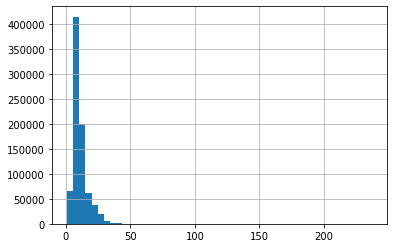

In [27]:
train_full_word.hist(bins = 50)

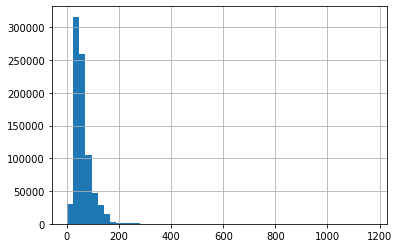

In [29]:
train_full_char.hist(bins = 50)

### Test set

In [30]:
test['question1_length'] = test['question1'].apply(lambda x:len(x.split(' ')))
test['question2_length'] = test['question2'].apply(lambda x:len(x.split(' ')))
test['question1_length_char'] =  test['question1'].apply(len)
test['question2_length_char'] =  test['question2'].apply(len)
test_full_word = pd.Series(test['question1_length'].tolist() + test['question2_length'].tolist())
test_full_char = pd.Series(test['question1_length_char'].tolist() + test['question2_length_char'].tolist())
print('word mean:',test_full_word.mean())
print('character mean:',test_full_char.mean())

word mean: 11.024308806051335
character mean: 60.070103282638385


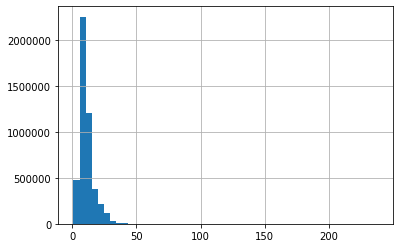

In [31]:
test_full_word.hist(bins = 50)

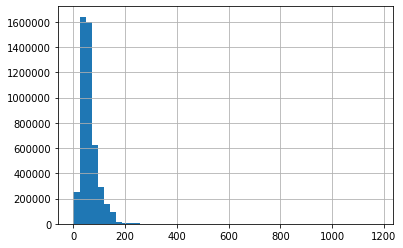

In [32]:
test_full_char.hist(bins = 50)

### For both set, generate a word cloud

(-0.5, 1439.5, 1079.5, -0.5)

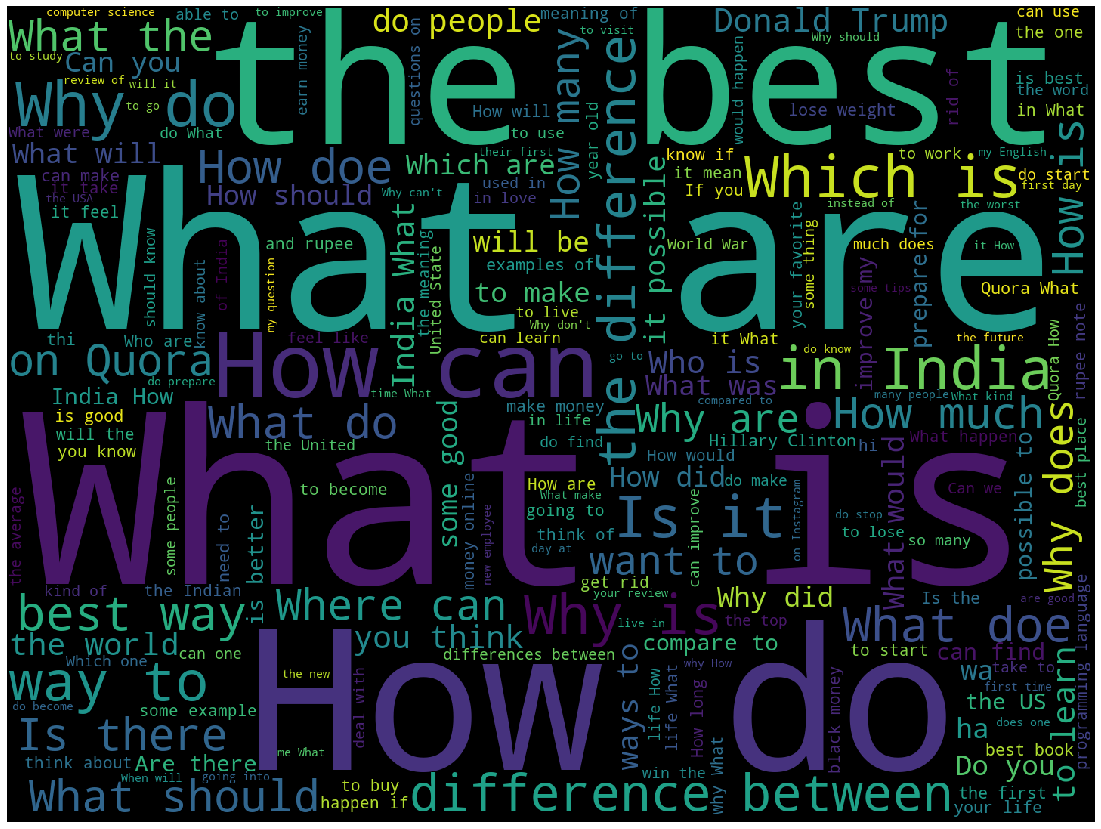

In [41]:
train_full = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
train_cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_full.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(train_cloud)
plt.axis('off')

(-0.5, 1439.5, 1079.5, -0.5)

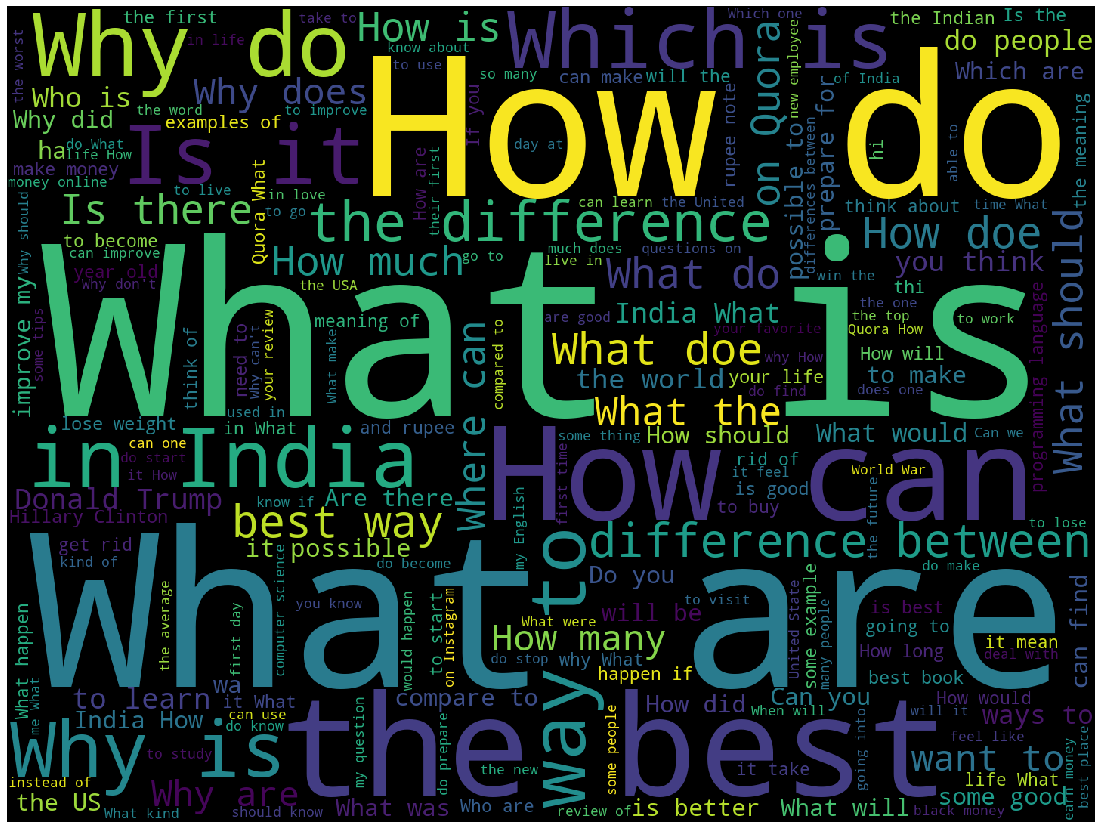

In [42]:
test_full = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)
test_cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_full.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(test_cloud)
plt.axis('off')

## Extract features

define the features:

    Jaccard: len(Q1 ∩ Q2) /len(Q1 ∪ Q2)
    
    Len1: len(Q1)
    
    Len2: len(Q2)
    
    Len1_unique: len(Q1- Q1 ∩ Q2)
    
    Len2_unique: len(Q2- Q1 ∩ Q2)
    
    Len_diff: |len(Q1) - len(Q2)|
    

In [84]:
def safe_divide(x, y, val=0.0):
    if y != 0.0:
        val = float(x) / float(y)
    return val

def get_jaccard(seq1, seq2):
    return 1 -  safe_divide(len(set(seq1) & set(seq2)),len(set(seq1) | set(seq2)))

def get_len(seq):
    return len(seq)

def get_len_unique(seq1,seq2):
    set1 = set(seq1)
    set2 = set(seq2)
    intersection = len(set(seq1) & set(seq2))
    return len(set1) -intersection

def get_features(seq1,seq2):

    jaccard = np.array([ get_jaccard(x1,x2) for x1,x2 in zip(seq1,seq2)]).reshape(-1,1)
    len1 = np.array([ get_len(x1)  for x1 in  seq1]).reshape(-1,1)
    len2 = np.array([ get_len(x2)  for x2 in  seq2]).reshape(-1,1)

    len1_unique = np.array([ get_len_unique(x1,x2)  for x1,x2 in  zip(seq1,seq2)]).reshape(-1,1)
    len2_unique = np.array([ get_len_unique(x2,x1)  for x1,x2 in  zip(seq1,seq2)]).reshape(-1,1)

    len_diff = np.abs(len2-len1)


    features = np.hstack([jaccard,len1,len2,len1_unique,len2_unique,len_diff])
    

    return features
    #return X_jaccard



Extract features for both set

In [85]:
x = get_features(train['question1'].apply(lambda x:x.split(' ')),train['question2'].apply(lambda x:x.split(' ')))
x_test = get_features(test['question1'].apply(lambda x:x.split(' ')),test['question2'].apply(lambda x:x.split(' ')))
#x = get_sim_feature(train['question1'].apply(lambda x:x.split(' ')),train['question2'].apply(lambda x:x.split(' ')))
#x_test = get_sim_feature(test['question1'].apply(lambda x:x.split(' ')),test['question2'].apply(lambda x:x.split(' ')))
y = train['is_duplicate'].values

scaler = StandardScaler()
x = scaler.fit_transform(x)
X_test = scaler.transform(x_test)

X_train,X_val,y_train,y_val = train_test_split(x,y,train_size=0.8,random_state=1024)

## Try linear model and tree-based model

### Linear model

In [86]:
linear_model = LogisticRegression(C=1)
linear_model.fit(X_train,y_train)

y_pred = linear_model.predict_proba(X_val)[:,1]
eval_score = log_loss(y_val,y_pred)
print(eval_score)

/Users/jesseooo/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5837248015138297


Make the submission file

In [87]:
y_pred_test = linear_model.predict_proba(X_test)[:,1]

submission = pd.DataFrame()
submission['test_id'] = test['test_id']
submission['is_duplicate'] = y_pred_test
submission.to_csv('submission/submission_linear.csv',index=False)

### Tree-based model

In [88]:
lgb_params = {"boosting": "gbdt", 'learning_rate': 0.05,"feature_fraction": 0.6, "bagging_freq": 1, 
              "bagging_fraction": 0.8 , 'n_estimators': 100000,"metric": 'mae', "lambda_l1": 0.1, 
              'num_leaves': 32, 'min_data_in_leaf': 50, "verbose": 1, "num_threads": 8,"bagging_seed" : 1024,
              "seed": 1024,'feature_fraction_seed': 1024,}

tree_model = lgb.LGBMClassifier(**lgb_params)
tree_model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)], verbose = 200, eval_metric ='logloss',early_stopping_rounds=200)     
y_pred = tree_model.predict_proba(X_val)[:,1]
eval_score = log_loss(y_val,y_pred)
print(eval_score)

Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.512873	training's l1: 0.355758	valid_1's binary_logloss: 0.51598	valid_1's l1: 0.357402
[400]	training's binary_logloss: 0.509788	training's l1: 0.354029	valid_1's binary_logloss: 0.515311	valid_1's l1: 0.356408
[600]	training's binary_logloss: 0.507698	training's l1: 0.352834	valid_1's binary_logloss: 0.515225	valid_1's l1: 0.355902
[800]	training's binary_logloss: 0.506007	training's l1: 0.35189	valid_1's binary_logloss: 0.515197	valid_1's l1: 0.355502
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.5067	training's l1: 0.352269	valid_1's binary_logloss: 0.515173	valid_1's l1: 0.355644
0.515173418618113


In [89]:
y_pred_test = tree_model.predict_proba(X_test)[:,1]

submission = pd.DataFrame()
submission['test_id'] = test['test_id']
submission['is_duplicate'] = y_pred_test
submission.to_csv('submission/submission_tree.csv',index=False)

plot the importance of features

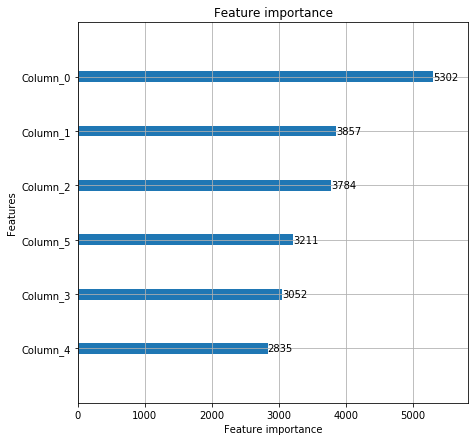

In [90]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
lgb.plot_importance(tree_model); 
plt.savefig('picture/features.jpg')
plt.show()